# 트렌드 전체 데이터 불러오기(RDS에서)

In [2]:
from pyspark.sql import *
import pandas as pd
import seaborn as sns
import pyspark

conf = pyspark.SparkConf()\
        .setAppName("spark-sql")\
        .set("spark.driver.extraClassPath", "./driver/mysql-connector-java-8.0.17.jar")
sc = pyspark.SparkContext(conf=conf)
sqlCtx = SQLContext(sc)
spark = sqlCtx.sparkSession
sql_url = "book.cvmrepjyvhmd.ap-northeast-2.rds.amazonaws.com"
user = "admin"
password = "pooiiioop"
database = "kyobobook"
table = "trends"
jdbc = spark.read.format("jdbc")\
                .option("driver", "com.mysql.cj.jdbc.Driver")\
                .option("url", "jdbc:mysql://{}:3306/{}?serverTimezone=Asia/Seoul ".format(sql_url, database))\
                .option("user", user)\
                .option("password", password)\
                .option("dbtable", table)\
                .load()
jdbc.show()

C:\Users\taeun\anaconda3\lib\site-packages\pyspark\sql\context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-----+--------------------+---------------------------------+---------------+---------------------------------+-----------------------------------+---------------------------------+
|index|                year|                        book_name|book_categories|                             hash|                              intro|                              pub|
+-----+--------------------+---------------------------------+---------------+---------------------------------+-----------------------------------+---------------------------------+
|    0|2021.01.01 ~ 2021...|주린이가 가장 알고 싶은 최다질...|      경제/경영|  #주식투자 #주식시장 #재테크 ...|         2020년 100조 원이 넘는 ...|      2021년 주식시장은 2020년...|
|    1|2021.01.01 ~ 2021...|                   2030 축의 전환|      경제/경영|  #경제전망 #미래예측 #경제학 ...|   4차 산업혁명 다음 혁명은 어느...|★출간 즉시 《월스트리트 저널》...|
|    2|2021.01.01 ~ 2021...|    부자 아빠 가난한 아빠. 1(2...|      경제/경영| #경제이야기 #부자되는법 #재테...|  기존 《부자 아빠 가난한 아빠》...| 전 세계에서 가장 많이 팔린 경...|
|    3|2021.01.01 ~ 2021...|     돈의 속

In [3]:
jdbc.createOrReplaceTempView("trends")

# 카테고리별 테이블 분리(None값 제거)

In [4]:
query = """
    SELECT year, concat_ws('', collect_list(info)) as concat
    FROM (SELECT year, book_categories, concat(intro, pub) as info FROM trends) as a
    WHERE info NOT IN ('','.',' ','None','NaNn') and book_categories='경제/경영'
    GROUP BY year
    ORDER BY year asc
"""

query1 = """
    SELECT year, concat_ws('', collect_list(info)) as concat
    FROM (SELECT year, book_categories, concat(intro, pub) as info FROM trends) as a
    WHERE info NOT IN ('','.',' ','None','NaNn') and book_categories='여행'
    GROUP BY year
    ORDER BY year asc
"""

query2 = """
    SELECT year, concat_ws('', collect_list(info)) as concat
    FROM (SELECT year, book_categories, concat(intro, pub) as info FROM trends) as a
    WHERE info NOT IN ('','.',' ','None','NaNn') and book_categories='컴퓨터/IT'
    GROUP BY year
    ORDER BY year asc
"""

kj = pd.DataFrame(spark.sql(query).collect(), columns=['year', 'contents']).set_index('year')
trip = pd.DataFrame(spark.sql(query1).collect(), columns=['year', 'contents']).set_index('year')
it = pd.DataFrame(spark.sql(query2).collect(), columns=['year', 'contents']).set_index('year')

kj

,contents
year,
2012.01.01 ~ 2012.12.31,북소믈리에 한마디!\n사생활을 철저하게 보호하기로 유명한 스티브 잡스는 2004년 ...
2013.01.01 ~ 2013.12.31,북소믈리에 한마디!\n이 책은 돈과 권력으로도 들을 수 없고 오직 극소수의 특권층에...
2014.01.01 ~ 2014.12.31,우리의 삶에서 '먹고 사는' 문제는 중요한 화두다. 이 먹고 사는데 필요한 '돈'은...
2015.01.01 ~ 2015.12.31,더 이상 예측할 수 없는 미래. 대부분의 학자들은 기술 개발의 역사로부터 추측해서 ...
2016.01.01 ~ 2016.12.31,"스티브 잡스, 마틴 루서 킹, 에이브러햄 링컨…. 세상을 변화시킨 독창적 리더들은 ..."
2017.01.01 ~ 2017.12.31,‘다보스 포럼’이란 명칭으로 익숙한 세계경제포럼은 올해 46주년을 맞이했다. 이 포...
2018.01.01 ~ 2018.12.31,『주식투자 무작정 따라하기』는 글로벌 악재와 급변하는 시장환경에 따라 등락을 거듭하...
2019.01.01 ~ 2019.12.31,"조직에서는 신입 사원이, 시장에서는 트렌드를 이끄는 주요 소비자가 되어 우리 곁에 ..."
2020.01.01 ~ 2020.12.31,"맨손에서 만들어낸 종잣돈으로 돈 버는 방법을 알려준다. 부모에게 받은 유산은 커녕,..."


# 자연어 분석에 넣을 데이터 준비

In [111]:
!pip install soynlp
!pip install konlpy

### 문장 토큰화 (Hannanum 사용 - 명사만 추출), 불용어 처리

# ▼ 전체 데이터 토큰화 -> 히스토그램 키워드 제거 기준 설정(후 불용어 처리)

In [ ]:
def rnn_data_all(data):
    
    data_vocab = data.copy()
    data_vocab['contents'].values
    data_vocab['contents_refined'] = data_vocab['contents'].apply(lambda x : re.sub("[^a-zA-Z가-힣\s]", '', x))
    
#     word_extractor = WordExtractor(
#         min_frequency=10,
#         min_cohesion_forward=0.05, 
#         min_right_branching_entropy=0.0 
#     )

#     word_extractor.train(data_vocab['contents_refined'].values)
#     words = word_extractor.extract()

#     cohesion_score = { word : score.cohesion_forward for word, score in words.items() }

    tokenizer = Hannanum()

    data_vocab['tokenize'] = data_vocab['contents_refined'].apply(lambda x : tokenizer.nouns(x))
    words = sum(data_vocab['tokenize'], [])

    count = Counter(words)
    words_dict = dict(count)

    # 리뷰 불용어 처리에서 
#     stopwords = {'것다','게','게끔','게나','게나마','게는','게도','게라도','게만','게만은','게시리','게요','고','고는','고도','고만','고말고','고서','고서는','고서도','고선','고야','고요','고자','곤','관데','구나','구려','구료','구먼','군','군요','기','기까지','기까지는','기까지도','기까지만','기까지만은','기로','기로서','기로서니','기로선들','기에','긴','길','나','나니','나마','나요','나이까','나이다','냐','냐고','냐는','냐라고','냐라고도','냐라고만','냐에','네','네만','네요','노','노라','노라고','노라니','노라면','느냐','느냐고','느냐는','느냐라고','느냐라고는','느냐라고도','느냐라고만','느냐라고만은','느냐에','느뇨','느니','느니라','느니만','느라','느라고','는','는가','는가라고','는가라는','는가를','는가에','는걸','는고','는구나','는구려','는구료','는구먼','는군','는다','는다거나','는다고','는다고는','는다는','는다는데','는다니','는다니까','는다든지','는다마는','는다만','는다만은','는다며','는다며는','는다면','는다면서','는다면은','는단다','는담','는답니까','는답니다','는답디까','는답디다','는답시고','는대','는대로','는대서','는대서야','는대야','는대요','는데','는데는','는데다','는데도','는데서','는만큼','는만큼만','는바','는지','는지가','는지고','는지는','는지도','는지라','는지를','는지만','는지에','는지요','는지의','니','니까','니까는','니깐','니라','니만치','니만큼','다','다가','다가는','다가도','다간','다거나','다고','다고까지','다고까지는','다고까지도','다고까지라도','다고까지만','다고까지만은','다고는','다고도','다고만','다고만은','다고요','다곤','다느냐','다느니','다는','다는데','다니','다마는','다마다','다만','다만은','다며','다며는','다면','다면서','다면서도','다면야','다면은','다시피','다오','단','단다','담','답시고','더구나','더구려','더구먼','더군','더군요','더냐','더니','더니라','더니마는','더니만','더라','더라도','더라며는','더라면','더란','더면','던','던가','던가요','던걸','던걸요','던고','던데','던데다','던데요','던들','던지','데','데도','데요','도록','도록까지','도록까지도','도록까지만','도록까지만요','도록까지만은','되','든','든지','듯','듯이','디','라','라고','라고까지','라고까지는','라고까지도','라고까지만','라고까지만은','라고는','라고도','라고만','라고만은','라곤','라느니','라는','라는데','라는데도','라는데요','라니','라니까','라니까요','라도','라든지','라며','라면','라면서','라면서까지','라면서까지도','라면서도','라면서요','란','란다','란다고','람','랍니까','랍니다','랍디까','랍디다','랍시고','래','래도','랴','랴마는','러','러니','러니라','러니이까','러니이다','러만','러만은','러이까','러이다','런가','런들','려','려거든','려고','려고까지','려고까지도','려고까지만','려고까지만은','려고는','려고도','려고만','려고만은','려고요','려기에','려나','려네','려느냐','려는','려는가','려는데','려는데요','려는지','려니','려니까','려니와','려다','려다가','려다가는','려다가도','려다가요','려더니','려더니만','려던','려면','려면요','려면은','려무나','련','련마는','련만','렴','렷다','리','리까','리니','리니라','리다','리라','리라는','리란','리로다','리만치','리만큼','리요','리요마는','마','매','며','며는','면','면서','면서까지','면서까지도','면서까지만은','면서도','면서부터','면서부터는','면요','면은','므로','사','사오이다','사옵니까','사옵니다','사옵디까','사옵디다','사외다','세','세요','소','소서','소이다','쇠다','습니까','습니다','습니다마는','습니다만','습디까','습디다','습디다마는','습디다만','아','아다','아다가','아도','아라','아서','아서까지','아서는','아서도','아서만','아서요','아선','아야','아야만','아요','어','어다','어다가','어도','어라','어서','어서까지','어서는','어서도','어서만','어서만은','어선','어야','어야만','어야지','어야지만','어요','어지이다','언정','엇다','오','오리까','오리까마는','오리까만','오리다','오이다','올습니다','올습니다마는','올습니다만','올시다','옵나이까','옵나이다','옵니까','옵니다','옵니다만','옵디까','옵디다','외다','요','으나','으나마','으냐','으냐고','으니','으니까','으니까는','으니깐','으니라','으니만치','으니만큼','으라','으라고','으라고까지','으라고까지는','으라고까지도','으라고까지만은','으라고는','으라고도','으라고만','으라고만은','으라고요','으라느니','으라는','으라니','으라니까','으라든지','으라며','으라면','으라면서','으라면은','으란','으람','으랍니까','으랍니다','으래','으래서','으래서야','으래야','으래요','으랴','으랴마는','으러','으러까지','으러까지도','으려','으려거든','으려고','으려고까지','으려고까지는','으려고까지도','으려고까지만','으려고까지만은','으려고는','으려고도','으려고만','으려고만은','으려고요','으려기에','으려나','으려느냐','으려느냐는','으려는','으려는가','으려는데','으려는데도','으려는데요','으려는지','으려니','으려니까','으려니와','으려다','으려다가','으려다가는','으려다가요','으려다간','으려더니','으려면','으려면야','으려면은','으려무나','으려서야','으려오','으련','으련다','으련마는','으련만','으련만은','으렴','으렵니까','으렵니다','으렷다','으리','으리까','으리니','으리니라','으리다','으리라','으리로다','으리만치','으리만큼','으리요','으마','으매','으며','으면','으면서','으면서까지','으면서까지도','으면서까지만','으면서까지만은','으면서는','으면서도','으면서부터','으면서부터까지','으면서부터까지도','으면서부터는','으면서요','으면요','으면은','으므로','으세요','으셔요','으소서','으시어요','으오','으오리까','으오리다','으오이다','으옵니까','으옵니다','으옵니다만','으옵디까','으옵디다','으외다','으이','은','은가','은가를','은가에','은가에도','은가에만','은가요','은걸','은걸요','은고','은다고','은다고까지','은다고까지도','은다고는','은다는','은다는데','은다니','은다니까','은다든지','은다마는','은다면','은다면서','은다면서도','은다면요','은다면은','은단다','은담','은답니까','은답니다','은답디까','은답디다','은답시고','은대','은대서','은대서야','은대야','은대요','은데','은데는','은데다','은데도','은데도요','은데서','은들','은만큼','은만큼도','은만큼만은','은만큼은','은바','은즉','은즉슨','은지','은지가','은지고','은지는','은지도','은지라','은지라도','은지를','은지만','은지만은','은지요','을','을거나','을거냐','을거다','을거야','을거지요','을걸','을까','을까마는','을까봐','을까요','을께','을께요','을꼬','을는지','을는지요','을라','을라고','을라고까지','을라고까지도','을라고까지만','을라고는','을라고도','을라고만','을라고만은','을라고요','을라요','을라치면','을락','을래','을래도','을래요','을러니','을러라','을런가','을런고','을레','을레라','을만한','을망정','을밖에','을밖에요','을뿐더러','을새','을세라','을세말이지','을소냐','을수록','을쏘냐','을이만큼','을작이면','을지','을지가','을지나','을지니','을지니라','을지도','을지라','을지라도','을지어다','을지언정','을지요','을진대','을진댄','을진저','을테다','을텐데','음','음세','음에도','음에랴','읍쇼','읍시다','읍시다요','읍시오','자','자고','자고까지','자고까지는','자고까지라도','자고는','자고도','자고만','자고만은','자꾸나','자는','자마자','자면','자면요','잔','잘','지','지는','지도','지를','지마는','지만','지요','진','질','가','같이','같이나','같이는','같이는야','같이는커녕','같이도','같이만','같인','고','과','과는','과는커녕','과도','과를','과만','과만은','과의','까지','까지가','까지나','까지나마','까지는','까지는야','까지는커녕','까지도','까지든지','까지라고','까지라고는','까지라고만은','까지라도','까지로','까지로나','까지로나마','까지로는','까지로는야','까지로는커녕','까지로도','까지로든','까지로든지','까지로라서','까지로라야','까지로만','까지로만은','까지로서','까지로써','까지를','까지만','까지만은','까지만이라도','까지야','까지야말로','까지에','까지와','까지의','까지조차','까지조차도','까진','께옵서','께옵서는','께옵서는야','께옵서는커녕','께옵서도','께옵서만','께옵서만은','께옵서만이','께옵선','나','나마','는','는야','는커녕','니','다','다가','다가는','다가도','다간','대로','대로가','대로는','대로의','더러','더러는','더러만은','도','든','든지','라','라고','라고까지','라고까지는','라고는','라고만은','라곤','라도','라든지','라서','라야','라야만','라오','라지','라지요','랑','랑은','로고','로구나','로구려','로구먼','로군','로군요','로다','로되','로세','를','마다','마다라도','마다를','마다에게','마다의','마따나','마저','마저나마라도','마저도','마저라도','마저야','만','만도','만에','만으로','만으로는','만으로도','만으로라도','만으로써','만으론','만은','만을','만의','만이','만이라도','만치','만큼','만큼도','만큼만','만큼씩','만큼은','만큼의','만큼이나','만큼이라도','만큼이야','말고','말고는','말고도','며','밖에','밖에는','밖에도','밖엔','보고','보고는','보고도','보고만','보고만은','보고만이라도','보곤','보다','보다는','보다는야','보다도','보다만','보다야','보단','부터','부터가','부터나마','부터는','부터도','부터라도','부터를','부터만','부터만은','부터서는','부터야말로','부터의','부턴','아','야','야말로','에','에게','에게가','에게까지','에게까지는','에게까지는커녕','에게까지도','에게까지만','에게까지만은','에게나','에게는','에게는커녕','에게다','에게도','에게든','에게든지','에게라도','에게로','에게로는','에게마다','에게만','에게며','에게보다','에게보다는','에게부터','에게서','에게서가','에게서까지','에게서나','에게서는','에게서도','에게서든지','에게서라도','에게서만','에게서보다','에게서부터','에게서야','에게서와','에게서의','에게서처럼','에게선','에게야','에게와','에게의','에게처럼','에게하고','에게하며','에겐','에까지','에까지는','에까지도','에까지든지','에까지라도','에까지만','에까지만은','에까진','에나','에는','에다','에다가','에다가는','에다간','에도','에든','에든지','에라도','에로','에로의','에를','에만','에만은','에부터','에서','에서가','에서까지','에서까지도','에서나','에서나마','에서는','에서도','에서든지','에서라도','에서만','에서만도','에서만이','에서만큼','에서만큼은','에서보다','에서부터','에서부터는','에서부터도','에서부터라도','에서부터만','에서부터만은','에서야','에서와','에서와는','에서와의','에서의','에서조차','에서처럼','에선','에야','에의','에조차도','에하며','엔','엔들','엘','엘랑','여','와','와는','와도','와라도','와를','와만','와만은','와에만','와의','와처럼','와한테','요','으로','으로가','으로까지','으로까지만은','으로나','으로나든지','으로는','으로도','으로든지','으로라도','으로랑','으로만','으로만은','으로부터','으로부터는','으로부터는커녕','으로부터도','으로부터만','으로부터만은','으로부터서는','으로부터서도','으로부터서만','으로부터의','으로서','으로서가','으로서나','으로서는','으로서도','으로서든지','으로서라도','으로서만','으로서만도','으로서만은','으로서야','으로서의','으로선','으로써','으로써나','으로써는','으로써라도','으로써만','으로써야','으로야','으로의','으론','은','은커녕','을','의','이','이고','이나','이나마','이니','이다','이든','이든지','이라','이라고','이라고는','이라고도','이라고만은','이라곤','이라는','이라도','이라든지','이라서','이라야','이라야만','이랑','이랑은','이며','이며에게','이며조차도','이야','이야말로','이여','인들','인즉','인즉슨','일랑','일랑은','조차','조차가','조차도','조차를','조차의','처럼','처럼과','처럼도','처럼만','처럼만은','처럼은','처럼이라도','처럼이야','치고','치고는','커녕','커녕은','커니와','토록','하고','하고가','하고는','하고는커녕','하고도','하고라도','하고마저','하고만','하고만은','하고야','하고에게','하고의','하고조차','하고조차도','하곤','있다','수'}
    stopwords = {'것', '수', '등'}
    
    for word in stopwords:
        if word in words_dict:
            words_dict.pop(word)
        else:
            pass
    return(words_dict)
    

# ▼ 연도별 데이터 토큰화 -> 시각화에 사용

In [5]:
def rnn_data(data, year):
    
    data_vocab = data.copy()
    data_vocab = data_vocab.iloc[int(year)-1:int(year)]
    data_vocab['contents'].values
    data_vocab['contents_refined'] = data_vocab['contents'].apply(lambda x : re.sub("[^a-zA-Z가-힣\s]", '', x))
    
#     word_extractor = WordExtractor(
#         min_frequency=10,
#         min_cohesion_forward=0.05, 
#         min_right_branching_entropy=0.0 
#     )

#     word_extractor.train(data_vocab['contents_refined'].values)
#     words = word_extractor.extract()

#     cohesion_score = { word : score.cohesion_forward for word, score in words.items() }

    tokenizer = Hannanum()

    data_vocab['tokenize'] = data_vocab['contents_refined'].apply(lambda x : tokenizer.nouns(x))
    words = sum(data_vocab['tokenize'], [])

    count = Counter(words)
    words_dict = dict(count)

    # 리뷰 불용어 처리에서 
#     stopwords = {'것다','게','게끔','게나','게나마','게는','게도','게라도','게만','게만은','게시리','게요','고','고는','고도','고만','고말고','고서','고서는','고서도','고선','고야','고요','고자','곤','관데','구나','구려','구료','구먼','군','군요','기','기까지','기까지는','기까지도','기까지만','기까지만은','기로','기로서','기로서니','기로선들','기에','긴','길','나','나니','나마','나요','나이까','나이다','냐','냐고','냐는','냐라고','냐라고도','냐라고만','냐에','네','네만','네요','노','노라','노라고','노라니','노라면','느냐','느냐고','느냐는','느냐라고','느냐라고는','느냐라고도','느냐라고만','느냐라고만은','느냐에','느뇨','느니','느니라','느니만','느라','느라고','는','는가','는가라고','는가라는','는가를','는가에','는걸','는고','는구나','는구려','는구료','는구먼','는군','는다','는다거나','는다고','는다고는','는다는','는다는데','는다니','는다니까','는다든지','는다마는','는다만','는다만은','는다며','는다며는','는다면','는다면서','는다면은','는단다','는담','는답니까','는답니다','는답디까','는답디다','는답시고','는대','는대로','는대서','는대서야','는대야','는대요','는데','는데는','는데다','는데도','는데서','는만큼','는만큼만','는바','는지','는지가','는지고','는지는','는지도','는지라','는지를','는지만','는지에','는지요','는지의','니','니까','니까는','니깐','니라','니만치','니만큼','다','다가','다가는','다가도','다간','다거나','다고','다고까지','다고까지는','다고까지도','다고까지라도','다고까지만','다고까지만은','다고는','다고도','다고만','다고만은','다고요','다곤','다느냐','다느니','다는','다는데','다니','다마는','다마다','다만','다만은','다며','다며는','다면','다면서','다면서도','다면야','다면은','다시피','다오','단','단다','담','답시고','더구나','더구려','더구먼','더군','더군요','더냐','더니','더니라','더니마는','더니만','더라','더라도','더라며는','더라면','더란','더면','던','던가','던가요','던걸','던걸요','던고','던데','던데다','던데요','던들','던지','데','데도','데요','도록','도록까지','도록까지도','도록까지만','도록까지만요','도록까지만은','되','든','든지','듯','듯이','디','라','라고','라고까지','라고까지는','라고까지도','라고까지만','라고까지만은','라고는','라고도','라고만','라고만은','라곤','라느니','라는','라는데','라는데도','라는데요','라니','라니까','라니까요','라도','라든지','라며','라면','라면서','라면서까지','라면서까지도','라면서도','라면서요','란','란다','란다고','람','랍니까','랍니다','랍디까','랍디다','랍시고','래','래도','랴','랴마는','러','러니','러니라','러니이까','러니이다','러만','러만은','러이까','러이다','런가','런들','려','려거든','려고','려고까지','려고까지도','려고까지만','려고까지만은','려고는','려고도','려고만','려고만은','려고요','려기에','려나','려네','려느냐','려는','려는가','려는데','려는데요','려는지','려니','려니까','려니와','려다','려다가','려다가는','려다가도','려다가요','려더니','려더니만','려던','려면','려면요','려면은','려무나','련','련마는','련만','렴','렷다','리','리까','리니','리니라','리다','리라','리라는','리란','리로다','리만치','리만큼','리요','리요마는','마','매','며','며는','면','면서','면서까지','면서까지도','면서까지만은','면서도','면서부터','면서부터는','면요','면은','므로','사','사오이다','사옵니까','사옵니다','사옵디까','사옵디다','사외다','세','세요','소','소서','소이다','쇠다','습니까','습니다','습니다마는','습니다만','습디까','습디다','습디다마는','습디다만','아','아다','아다가','아도','아라','아서','아서까지','아서는','아서도','아서만','아서요','아선','아야','아야만','아요','어','어다','어다가','어도','어라','어서','어서까지','어서는','어서도','어서만','어서만은','어선','어야','어야만','어야지','어야지만','어요','어지이다','언정','엇다','오','오리까','오리까마는','오리까만','오리다','오이다','올습니다','올습니다마는','올습니다만','올시다','옵나이까','옵나이다','옵니까','옵니다','옵니다만','옵디까','옵디다','외다','요','으나','으나마','으냐','으냐고','으니','으니까','으니까는','으니깐','으니라','으니만치','으니만큼','으라','으라고','으라고까지','으라고까지는','으라고까지도','으라고까지만은','으라고는','으라고도','으라고만','으라고만은','으라고요','으라느니','으라는','으라니','으라니까','으라든지','으라며','으라면','으라면서','으라면은','으란','으람','으랍니까','으랍니다','으래','으래서','으래서야','으래야','으래요','으랴','으랴마는','으러','으러까지','으러까지도','으려','으려거든','으려고','으려고까지','으려고까지는','으려고까지도','으려고까지만','으려고까지만은','으려고는','으려고도','으려고만','으려고만은','으려고요','으려기에','으려나','으려느냐','으려느냐는','으려는','으려는가','으려는데','으려는데도','으려는데요','으려는지','으려니','으려니까','으려니와','으려다','으려다가','으려다가는','으려다가요','으려다간','으려더니','으려면','으려면야','으려면은','으려무나','으려서야','으려오','으련','으련다','으련마는','으련만','으련만은','으렴','으렵니까','으렵니다','으렷다','으리','으리까','으리니','으리니라','으리다','으리라','으리로다','으리만치','으리만큼','으리요','으마','으매','으며','으면','으면서','으면서까지','으면서까지도','으면서까지만','으면서까지만은','으면서는','으면서도','으면서부터','으면서부터까지','으면서부터까지도','으면서부터는','으면서요','으면요','으면은','으므로','으세요','으셔요','으소서','으시어요','으오','으오리까','으오리다','으오이다','으옵니까','으옵니다','으옵니다만','으옵디까','으옵디다','으외다','으이','은','은가','은가를','은가에','은가에도','은가에만','은가요','은걸','은걸요','은고','은다고','은다고까지','은다고까지도','은다고는','은다는','은다는데','은다니','은다니까','은다든지','은다마는','은다면','은다면서','은다면서도','은다면요','은다면은','은단다','은담','은답니까','은답니다','은답디까','은답디다','은답시고','은대','은대서','은대서야','은대야','은대요','은데','은데는','은데다','은데도','은데도요','은데서','은들','은만큼','은만큼도','은만큼만은','은만큼은','은바','은즉','은즉슨','은지','은지가','은지고','은지는','은지도','은지라','은지라도','은지를','은지만','은지만은','은지요','을','을거나','을거냐','을거다','을거야','을거지요','을걸','을까','을까마는','을까봐','을까요','을께','을께요','을꼬','을는지','을는지요','을라','을라고','을라고까지','을라고까지도','을라고까지만','을라고는','을라고도','을라고만','을라고만은','을라고요','을라요','을라치면','을락','을래','을래도','을래요','을러니','을러라','을런가','을런고','을레','을레라','을만한','을망정','을밖에','을밖에요','을뿐더러','을새','을세라','을세말이지','을소냐','을수록','을쏘냐','을이만큼','을작이면','을지','을지가','을지나','을지니','을지니라','을지도','을지라','을지라도','을지어다','을지언정','을지요','을진대','을진댄','을진저','을테다','을텐데','음','음세','음에도','음에랴','읍쇼','읍시다','읍시다요','읍시오','자','자고','자고까지','자고까지는','자고까지라도','자고는','자고도','자고만','자고만은','자꾸나','자는','자마자','자면','자면요','잔','잘','지','지는','지도','지를','지마는','지만','지요','진','질','가','같이','같이나','같이는','같이는야','같이는커녕','같이도','같이만','같인','고','과','과는','과는커녕','과도','과를','과만','과만은','과의','까지','까지가','까지나','까지나마','까지는','까지는야','까지는커녕','까지도','까지든지','까지라고','까지라고는','까지라고만은','까지라도','까지로','까지로나','까지로나마','까지로는','까지로는야','까지로는커녕','까지로도','까지로든','까지로든지','까지로라서','까지로라야','까지로만','까지로만은','까지로서','까지로써','까지를','까지만','까지만은','까지만이라도','까지야','까지야말로','까지에','까지와','까지의','까지조차','까지조차도','까진','께옵서','께옵서는','께옵서는야','께옵서는커녕','께옵서도','께옵서만','께옵서만은','께옵서만이','께옵선','나','나마','는','는야','는커녕','니','다','다가','다가는','다가도','다간','대로','대로가','대로는','대로의','더러','더러는','더러만은','도','든','든지','라','라고','라고까지','라고까지는','라고는','라고만은','라곤','라도','라든지','라서','라야','라야만','라오','라지','라지요','랑','랑은','로고','로구나','로구려','로구먼','로군','로군요','로다','로되','로세','를','마다','마다라도','마다를','마다에게','마다의','마따나','마저','마저나마라도','마저도','마저라도','마저야','만','만도','만에','만으로','만으로는','만으로도','만으로라도','만으로써','만으론','만은','만을','만의','만이','만이라도','만치','만큼','만큼도','만큼만','만큼씩','만큼은','만큼의','만큼이나','만큼이라도','만큼이야','말고','말고는','말고도','며','밖에','밖에는','밖에도','밖엔','보고','보고는','보고도','보고만','보고만은','보고만이라도','보곤','보다','보다는','보다는야','보다도','보다만','보다야','보단','부터','부터가','부터나마','부터는','부터도','부터라도','부터를','부터만','부터만은','부터서는','부터야말로','부터의','부턴','아','야','야말로','에','에게','에게가','에게까지','에게까지는','에게까지는커녕','에게까지도','에게까지만','에게까지만은','에게나','에게는','에게는커녕','에게다','에게도','에게든','에게든지','에게라도','에게로','에게로는','에게마다','에게만','에게며','에게보다','에게보다는','에게부터','에게서','에게서가','에게서까지','에게서나','에게서는','에게서도','에게서든지','에게서라도','에게서만','에게서보다','에게서부터','에게서야','에게서와','에게서의','에게서처럼','에게선','에게야','에게와','에게의','에게처럼','에게하고','에게하며','에겐','에까지','에까지는','에까지도','에까지든지','에까지라도','에까지만','에까지만은','에까진','에나','에는','에다','에다가','에다가는','에다간','에도','에든','에든지','에라도','에로','에로의','에를','에만','에만은','에부터','에서','에서가','에서까지','에서까지도','에서나','에서나마','에서는','에서도','에서든지','에서라도','에서만','에서만도','에서만이','에서만큼','에서만큼은','에서보다','에서부터','에서부터는','에서부터도','에서부터라도','에서부터만','에서부터만은','에서야','에서와','에서와는','에서와의','에서의','에서조차','에서처럼','에선','에야','에의','에조차도','에하며','엔','엔들','엘','엘랑','여','와','와는','와도','와라도','와를','와만','와만은','와에만','와의','와처럼','와한테','요','으로','으로가','으로까지','으로까지만은','으로나','으로나든지','으로는','으로도','으로든지','으로라도','으로랑','으로만','으로만은','으로부터','으로부터는','으로부터는커녕','으로부터도','으로부터만','으로부터만은','으로부터서는','으로부터서도','으로부터서만','으로부터의','으로서','으로서가','으로서나','으로서는','으로서도','으로서든지','으로서라도','으로서만','으로서만도','으로서만은','으로서야','으로서의','으로선','으로써','으로써나','으로써는','으로써라도','으로써만','으로써야','으로야','으로의','으론','은','은커녕','을','의','이','이고','이나','이나마','이니','이다','이든','이든지','이라','이라고','이라고는','이라고도','이라고만은','이라곤','이라는','이라도','이라든지','이라서','이라야','이라야만','이랑','이랑은','이며','이며에게','이며조차도','이야','이야말로','이여','인들','인즉','인즉슨','일랑','일랑은','조차','조차가','조차도','조차를','조차의','처럼','처럼과','처럼도','처럼만','처럼만은','처럼은','처럼이라도','처럼이야','치고','치고는','커녕','커녕은','커니와','토록','하고','하고가','하고는','하고는커녕','하고도','하고라도','하고마저','하고만','하고만은','하고야','하고에게','하고의','하고조차','하고조차도','하곤','있다','수'}
    stopwords = {'것', '수', '등'}
    
    for word in stopwords:
        if word in words_dict:
            words_dict.pop(word)
        else:
            pass
    return(words_dict)
    

In [9]:
print(rnn_data(trip, 1)) 

{'이병률': 5, '여행': 463, '산문집바람': 1, '당신': 11, '시인': 8, '이소라': 2, '음악도시': 2, '구성작가': 2, '이': 25, '두': 16, '번': 24, '에세이': 7, '감성적': 2, '사진': 52, '글': 27, '책': 153, '사람': 40, '따뜻한': 5, '호': 7, '쓸쓸': 4, '저릿': 2, '마음': 24, '목차': 4, '페이지': 18, '순서': 5, '듯': 10, '구성': 11, '그': 35, '생각': 17, '기록들': 1, '오롯': 5, '위': 9, '인연': 2, '사랑': 27, '이야기': 22, '만나본다참': 1, '년': 69, '전': 27, '출간': 9, '때': 31, '신선한': 3, '충격': 1, '우리': 41, '목': 2, '당시': 1, '여행지': 70, '단순': 1, '정보': 162, '글자': 5, '나열': 2, '시장': 1, '날': 2, '감성': 8, '충만': 1, '여행산문집': 2, '그때': 2, '낭만': 14, '청춘들': 5, '책장': 1, '모서리': 1, '표지': 9, '이후': 4, '서점': 1, '코너': 6, '기록': 7, '평생교육원': 1, '사설': 1, '교육기관': 1, '여행작가': 3, '법': 6, '강': 3, '개설': 1, '기획': 1, '그곳': 12, '식': 6, '취재': 10, '스토리텔링': 1, '실제': 7, '촬영': 2, '기술적': 1, '테크닉': 1, '후폭풍이다': 1, '과장': 1, '사실': 5, '거': 4, '내겐': 1, '일': 50, '만': 9, '바람': 1, '세월': 4, '동안': 10, '작': 4, '그동안': 7, '속': 17, '곳': 76, '말': 22, '나라': 8, '도착': 4, '물': 3, '다음': 6, '나': 41, '누군가': 4, '죽': 6, '상태': 2, '눈빛': 2, '여행자

rnn_data(data, year)에서 year 값
* 2012 1
* 2013 2
* 2014 3
* 2015 4
* 2016 5
* 2017 6
* 2018 7
* 2019 8
* 2020 9
* 2021 10




## 키워드 분포도 빈도수 확인 후 히스토그램 그리고 빈도수 많은 키워드 제거(전체 데이터 기준)

*  max, mean, std 고려해서 키워드 제거할 단어 기준 설정하기

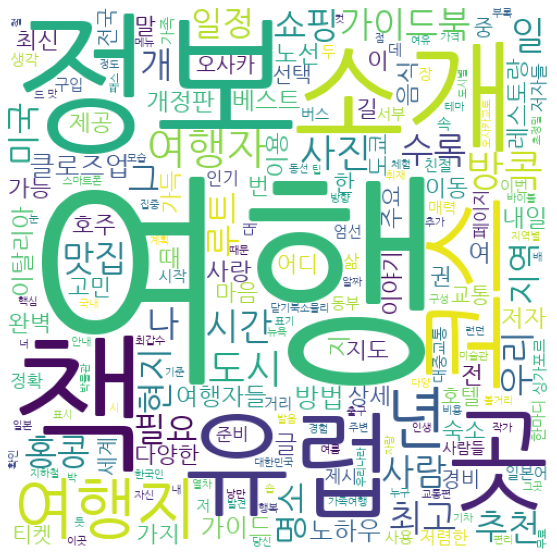

In [6]:
# 2012
from konlpy.tag import Hannanum
from collections import Counter
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import re


wordcloud = WordCloud(font_path='C:/Windows/Font/NanumGothic.ttf', # 폰트 지정
                      background_color='white', # 워드클라우드 배경색
                      width=500, height=500).generate_from_frequencies(rnn_data(trip, 1))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

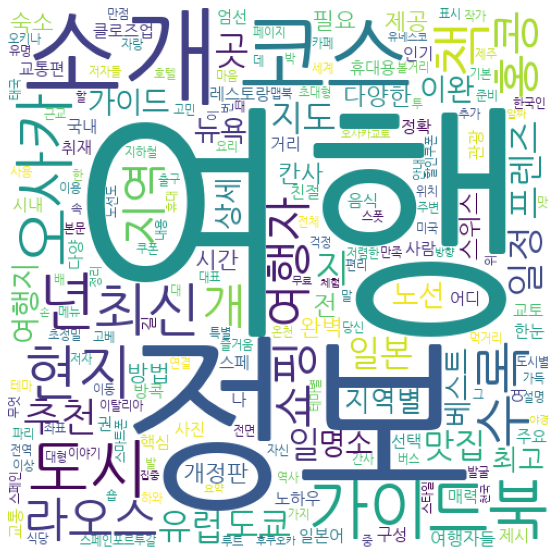

In [7]:
# 2015
from konlpy.tag import Hannanum
from collections import Counter
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import re


wordcloud = WordCloud(font_path='C:/Windows/Font/NanumGothic.ttf', # 폰트 지정
                      background_color='white', # 워드클라우드 배경색
                      width=500, height=500).generate_from_frequencies(rnn_data(trip, 4))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

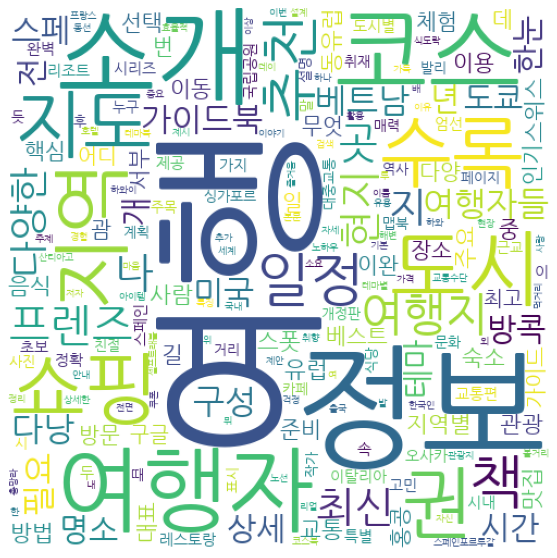

In [8]:
# 2019
from konlpy.tag import Hannanum
from collections import Counter
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import re


wordcloud = WordCloud(font_path='C:/Windows/Font/NanumGothic.ttf', # 폰트 지정
                      background_color='white', # 워드클라우드 배경색
                      width=500, height=500).generate_from_frequencies(rnn_data(trip, 8))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

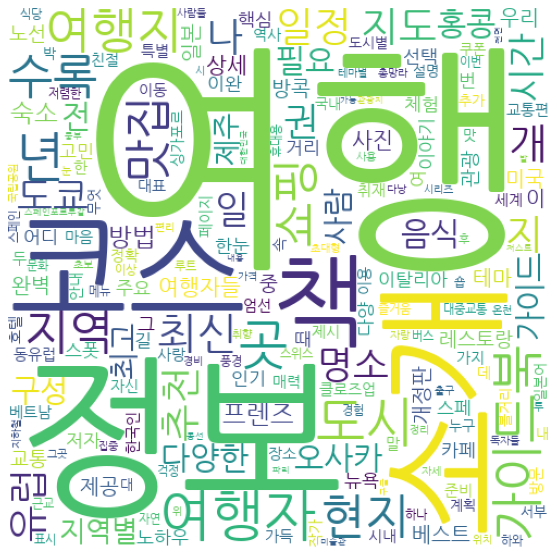

In [201]:
from konlpy.tag import Hannanum
from collections import Counter
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import re


wordcloud = WordCloud(font_path='C:/Windows/Font/NanumGothic.ttf', # 폰트 지정
                      background_color='white', # 워드클라우드 배경색
                      width=500, height=500).generate_from_frequencies(rnn_data(trip)[0])

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 데이터 넣어서 시각화

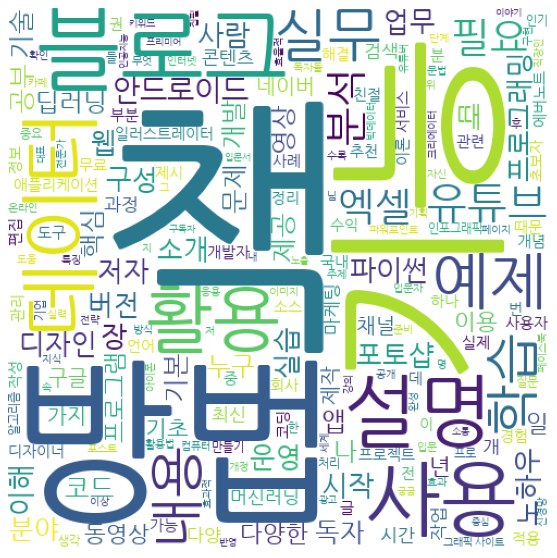

In [158]:
# 리뷰 분석에 사용
# from soynlp.word import WordExtractor
# from soynlp.tokenizer import LTokenizer

from konlpy.tag import Hannanum
from collections import Counter
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import re

wordcloud = WordCloud(font_path='C:/Windows/Font/NanumGothic.ttf', # 폰트 지정
                      background_color='white', # 워드클라우드 배경색
                      width=500, height=500).generate_from_frequencies(rnn_data(it))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

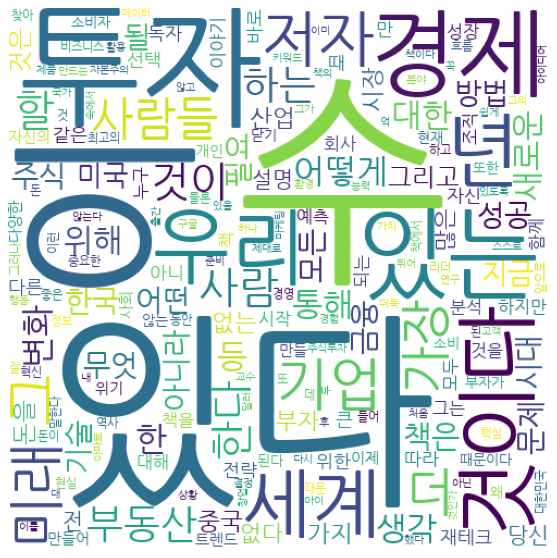

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()